# Introduction

Machine learning has a phenomenal range of applications, including in health and diagnostics. This tutorial will explain the complete pipeline from loading data to predicting results, and it will explain how to build an Breast Cancer image classification model from scratch to predict whether an image shows presence of malignant cancer.

**Follow the steps to download data from Kaggle 1st time**

Login in Kaggle and download the kaggle.json File from Kaggle settings.
**(One Time Activity)**

Click on the folder icon on left menu bar and upload the kaggle.json file.

In [ ]:
! pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
! mkdir ~/.kaggle

In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download paultimothymooney/breast-histopathology-images

Mount the Google Drive to move the downloaded zip file to google drive so that we don't have to download all the time

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


Create a folder as per mentioned below directory
***Colab Notebooks/Breast_Cancer_Classification/dataset***
Post that move the file using the below code

In [ ]:
mv '/content/breast-histopathology-images.zip' 'gdrive/MyDrive/Colab Notebooks/Breast_Cancer_Classification/dataset/'

 ---------------------------------------------------------------------

**Follow the below steps if you have the data zip file downloaded from kaggle in your gdrive**

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
mkdir /content/dataset/

In [ ]:
mkdir /content/dataset/initialPath

In [ ]:
mkdir /content/dataset/finalPath

In [ ]:
! unzip "gdrive/MyDrive/Colab Notebooks/Breast_Cancer_Classification/dataset/breast-histopathology-images" -d /content/dataset/initialPath

Streaming output truncated to the last 5000 lines.
  inflating: /content/dataset/initialPath/IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1551_class0.png  
  inflating: /content/dataset/initialPath/IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1601_class0.png  
  inflating: /content/dataset/initialPath/IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1651_class0.png  
  inflating: /content/dataset/initialPath/IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1701_class0.png  
  inflating: /content/dataset/initialPath/IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1751_class0.png  
  inflating: /content/dataset/initialPath/IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1801_class0.png  
  inflating: /content/dataset/initialPath/IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1851_class0.png  
  inflating: /content/dataset/initialPath/IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1901_class0.png  
  inflating: /content/dataset/initialPath/IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1951_class0.p

In [ ]:
mkdir /content/output

In [ ]:
mkdir /content/utils

In [ ]:
cp 'gdrive/MyDrive/Colab Notebooks/Breast_Cancer_Classification/utils/config.py' '/content/utils/config.py'

In [ ]:
cp 'gdrive/MyDrive/Colab Notebooks/Breast_Cancer_Classification/utils/conv_bc_model.py' '/content/utils/conv_bc_model.py'

In [ ]:
cp 'gdrive/MyDrive/Colab Notebooks/Breast_Cancer_Classification/utils/create_dataset.py' '/content/utils/create_dataset.py'

In [ ]:
cp 'gdrive/MyDrive/Colab Notebooks/Breast_Cancer_Classification/utils/getPaths.py' '/content/utils/getPaths.py'

Running the Build Dataset file to shuffle and create the train test val folders and files

In [ ]:
! python /content/utils/create_dataset.py

555048
555048
Making 'training' split
'Creating /content/dataset/finalPath/training' directory
'creating /content/dataset/finalPath/training/0' directory
'creating /content/dataset/finalPath/training/1' directory
Making 'validation' split
'Creating /content/dataset/finalPath/validation' directory
'creating /content/dataset/finalPath/validation/0' directory
'creating /content/dataset/finalPath/validation/1' directory
Making 'testing' split
'Creating /content/dataset/finalPath/testing' directory
'creating /content/dataset/finalPath/testing/1' directory
'creating /content/dataset/finalPath/testing/0' directory


-------------------------------------------------------------------------------

**Model Building and Evaluation**

In [ ]:
# # Mounting the google drive
# from google.colab import drive
# drive.mount('/content/gdrive')

In [ ]:
# # Google Drive Path
# gDrivePath = "gdrive/MyDrive/Colab Notebooks/Breast_Cancer_Classification/"

In [ ]:
# import sys
# sys.path.append(gDrivePath)

In [ ]:
# Setting the matplotlib backend so that if required then images can be saved in the background
import matplotlib
matplotlib.use("Agg")
%matplotlib inline

In [ ]:
# import the packages
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score
from tensorflow.keras.optimizers import Adam
from utils import config
from utils.conv_bc_model import BC_Model
import matplotlib.pyplot as plt
import numpy as np
import os
import glob
import pandas as pd
import seaborn as sns
import cv2

In [ ]:
# pip install seaborn

In [ ]:
# Defining a function for plotting the count of data against each class in each directory
def plotData(dirPath):
    # Get the path to the benign and malignant sub-directories
    benign_cases_dir = dirPath+ '/0/'
    malignant_cases_dir = dirPath + '/1/'

    # Get the list of all the images
    benign_cases = glob.glob(benign_cases_dir + '*.png')
    malignant_cases = glob.glob(malignant_cases_dir + '*.png')

    # An empty list. We will insert the data into this list in (img_path, label) format
    data1 = []

    # Go through all the benign cases. The label for these cases will be 0
    for img in benign_cases:
        data1.append((img,0))

    # Go through all the malignant cases. The label for these cases will be 1
    for img in malignant_cases:
        data1.append((img, 1))

    # Get a pandas dataframe from the data we have in our list 
    data1 = pd.DataFrame(data1, columns=['image', 'label'],index=None)

    # Shuffle the data 
    data1 = data1.sample(frac=1.).reset_index(drop=True)
    
    
    
    # Get the counts for each class
    cases_count = data1['label'].value_counts()
    print(cases_count)

    # Plot the results 
    plt.figure(figsize=(10,8))
    sns.barplot(x=cases_count.index, y= cases_count.values)
    plt.title('Number of cases', fontsize=14)
    plt.xlabel('Case type', fontsize=12)
    plt.ylabel('Count', fontsize=12)
    plt.xticks(range(len(cases_count.index)), ['benign(0)', 'malignant(1)'])
    plt.show()

0    183235
1     72627
Name: label, dtype: int64


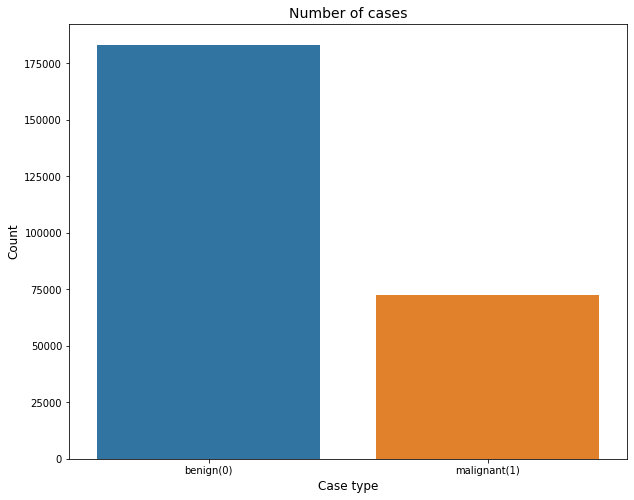

In [ ]:
plotData(config.TRAIN_PATH)

0    71433
1    28496
Name: label, dtype: int64


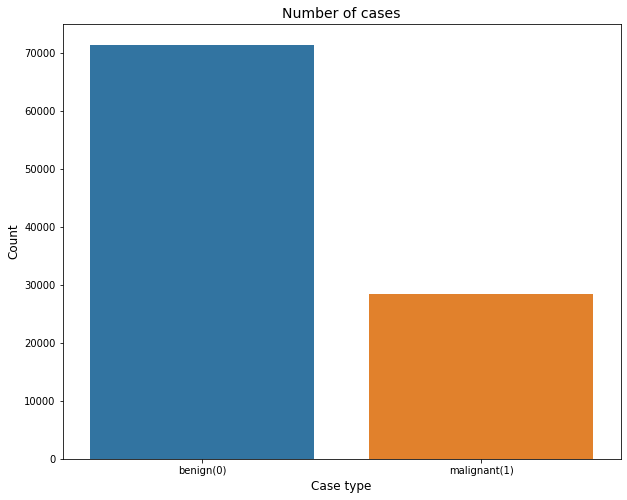

In [ ]:
plotData(config.TEST_PATH)

0    30611
1    12067
Name: label, dtype: int64


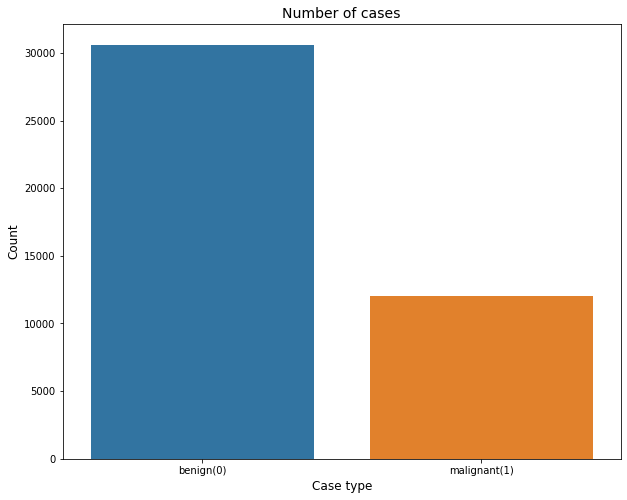

In [ ]:
plotData(config.VAL_PATH)

In [ ]:
# Get the path to the benign and malignant sub-directories
benign_cases_dir = config.TRAIN_PATH + '/0/'
malignant_cases_dir = config.TRAIN_PATH + '/1/'

# Get the list of all the images
benign_cases = glob.glob(benign_cases_dir + '*.png')
malignant_cases = glob.glob(malignant_cases_dir + '*.png')

# An empty list. We will insert the data into this list in (img_path, label) format
train_data1 = []

# Go through all the benign cases. The label for these cases will be 0
for img in benign_cases:
    train_data1.append((img,0))

# Go through all the malignant cases. The label for these cases will be 1
for img in malignant_cases:
    train_data1.append((img, 1))

# Get a pandas dataframe from the data we have in our list 
train_data1 = pd.DataFrame(train_data1, columns=['image', 'label'],index=None)

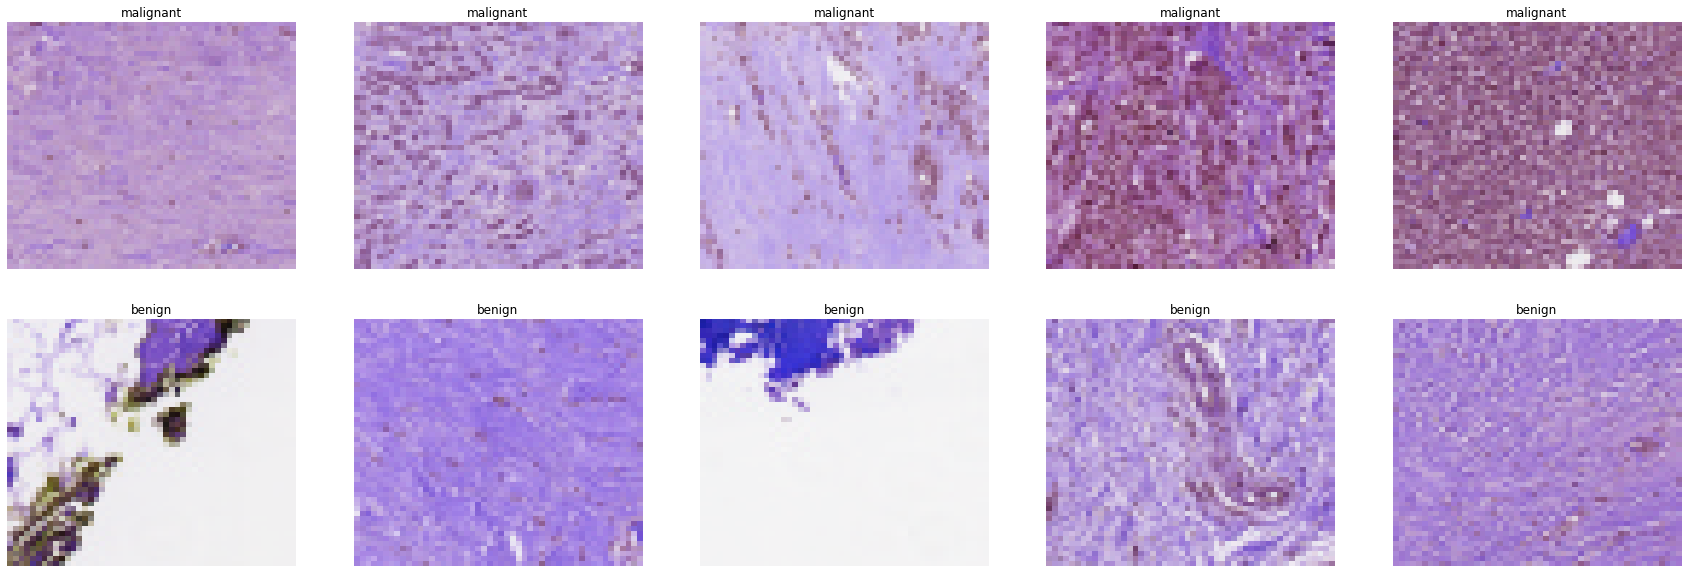

In [ ]:
# Get few samples for both the classes
malignant_samples = (train_data1[train_data1['label']==1]['image'].iloc[:5]).tolist()
benign_samples = (train_data1[train_data1['label']==0]['image'].iloc[:5]).tolist()

# Concat the data in a single list and del the above two list
samples = malignant_samples + benign_samples
del malignant_samples, benign_samples

# Plot the data 
f, ax = plt.subplots(2,5, figsize=(30,10))
for i in range(10):
    img = cv2.imread(samples[i])
    ax[i//5, i%5].imshow(img, cmap='gray')
    if i<5:
        ax[i//5, i%5].set_title("benign")
    else:
        ax[i//5, i%5].set_title("malignant")
    ax[i//5, i%5].axis('off')
    ax[i//5, i%5].set_aspect('auto')
plt.show()

If we look carefully, then there are some cases where we won't be able to differentiate between a benign case and a malignant case with the naked eye. If we can build a robust classifier, it would be a great assist for the doctor too.

In [ ]:
# Defining a method to get the number of files given a path
def retrieveNumberOfFiles(path):
    list1 = []
    for file_name in glob.iglob(path+'/**/*.png', recursive=True):
        list1.append(file_name)
    return len(list1)

In [ ]:
# Defining a method to plot training and validation accuracy and loss
def training_plot(H, N, plotPath):
    plt.style.use("ggplot")
    plt.figure()
    plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
    plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
    plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
    plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
    plt.title("Training Loss and Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Loss/Accuracy")
    plt.legend(loc="lower left")
    plt.savefig(plotPath)

In [ ]:
# Defining the paths to the training, validation, and testing directories
trainPath = config.TRAIN_PATH
valPath = config.VAL_PATH
testPath = config.TEST_PATH

In [ ]:
# Checking for the total number of image paths in training, validation and testing directories
totalTrain = retrieveNumberOfFiles(config.TRAIN_PATH)
totalVal = retrieveNumberOfFiles(config.VAL_PATH)
totalTest = retrieveNumberOfFiles(config.TEST_PATH)

In [ ]:
# Defining a method to get the list of files given a path
def getAllFiles(path):
    list1 = []
    for file_name in glob.iglob(path+'/**/*.png', recursive=True):
        list1.append(file_name)
    return list1

In [ ]:
# Retrieving all files from train directory
allTrainFiles = getAllFiles(config.TRAIN_PATH)

In [ ]:
# Calculating the total number of training images against each class and then store the class weights in a dictionary
trainLabels = [int(p.split(os.path.sep)[-2]) for p in allTrainFiles]
trainLabels = to_categorical(trainLabels)
classSumTotals = trainLabels.sum(axis=0)
classWeight = dict()

# Looping over all classes and calculate the class weights
for i in range(0, len(classSumTotals)):
    classWeight[i] = classSumTotals.max() / classSumTotals[i]

In [ ]:
# Initialize the training data augmentation object
## preprocess_input will scale input pixels between -1 and 1
## rotation_range is a value in degrees (0-180), a range within which to randomly rotate pictures
## zoom_range is for randomly zooming inside pictures
## width_shift and height_shift are ranges (as a fraction of total width or height) within which to randomly translate pictures vertically or horizontally
## shear_range is for randomly applying shearing transformations
## horizontal_flip and vertical_flip is for randomly flipping half of the images horizontally and vertically resp
## fill_mode is the strategy used for filling in newly created pixels, which can appear after a rotation or a width/height shift

trainAug = ImageDataGenerator(
	rescale=1 / 255.0,
	rotation_range=30,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	vertical_flip=True,
	fill_mode="nearest")

In [ ]:
# Initialize the validation data augmentation object
valAug = ImageDataGenerator(rescale=1/255.0)

In [ ]:
# Initialize the training generator
trainGen = trainAug.flow_from_directory(
	trainPath,
	class_mode="categorical",
	target_size=(48, 48),
	color_mode="rgb",
	shuffle=True,
	batch_size=config.BATCH_SIZE)

Found 255755 images belonging to 2 classes.


In [ ]:
# Initialize the validation generator
valGen = valAug.flow_from_directory(
	valPath,
	class_mode="categorical",
	target_size=(48, 48),
	color_mode="rgb",
	shuffle=False,
	batch_size=config.BATCH_SIZE)

Found 42620 images belonging to 2 classes.


In [ ]:
# Initialize the testing generator
testGen = valAug.flow_from_directory(
	testPath,
	class_mode="categorical",
	target_size=(48, 48),
	color_mode="rgb",
	shuffle=False,
	batch_size=config.BATCH_SIZE)

Found 99947 images belonging to 2 classes.


In [ ]:
# Building the model
print("Building the model")
model = BC_Model.build(width=48, height=48, depth=3, classes=2)

Building the model


In [ ]:
# Compiling the model
## Decay updates the learning rate by a decreasing factor in each epoch
print("Compiling the model")
opt = Adam(lr=config.INIT_LR, decay=config.INIT_LR / config.EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

Compiling the model


/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
# Using ModelCheckpoint to store the best performing model based on val_loss
MCName = os.path.sep.join([config.outputPath, "weights-{epoch:03d}-{val_loss:.4f}.hdf5"])
checkpoint = ModelCheckpoint(MCName, monitor="val_loss", mode="min", save_best_only=True, verbose=1)
callbacks = [checkpoint]

In [ ]:
# Fitting the model on training data
print("Fitting the Model")
MF = model.fit(
    x=trainGen,
    steps_per_epoch=totalTrain // config.BATCH_SIZE,
    validation_data=valGen,
    validation_steps=totalVal // config.BATCH_SIZE,
    class_weight=classWeight,
    callbacks=callbacks,
    epochs=config.EPOCHS)

Fitting the Model
Epoch 1/20
7995/7995 [==============================] - ETA: 0s - loss: 0.6506 - accuracy: 0.8107
Epoch 1: val_loss improved from inf to 0.40176, saving model to /content/output/weights-001-0.4018.hdf5
7995/7995 [==============================] - 605s 74ms/step - loss: 0.6506 - accuracy: 0.8107 - val_loss: 0.4018 - val_accuracy: 0.8354
Epoch 2/20
7995/7995 [==============================] - ETA: 0s - loss: 0.5483 - accuracy: 0.8356
Epoch 2: val_loss improved from 0.40176 to 0.34569, saving model to /content/output/weights-002-0.3457.hdf5
7995/7995 [==============================] - 497s 62ms/step - loss: 0.5483 - accuracy: 0.8356 - val_loss: 0.3457 - val_accuracy: 0.8502
Epoch 3/20
7995/7995 [==============================] - ETA: 0s - loss: 0.5198 - accuracy: 0.8455
Epoch 3: val_loss improved from 0.34569 to 0.32499, saving model to /content/output/weights-003-0.3250.hdf5
7995/7995 [==============================] - 454s 57ms/step - loss: 0.5198 - accuracy: 0.8455 - 

In [ ]:
# Loading the best performing model
# Please specify the model name from the output folder which has the lowest val_loss
path1 = config.outputPath + '/weights-010-0.3063.hdf5'
fModel = load_model(path1)

In [ ]:
# Predicting on the test data
print("Predicting on the test data")
predTest = fModel.predict(x=testGen, steps=(totalTest // config.BATCH_SIZE)+1)
predTest = np.argmax(predTest, axis=1)

Predicting on the test data
3124/3124 [==============================] - 715s 229ms/step


In [ ]:
# Printing the Classification Report
print(classification_report(testGen.classes, predTest,target_names=testGen.class_indices.keys()))

              precision    recall  f1-score   support

           0       0.93      0.90      0.91     71715
           1       0.76      0.82      0.79     28232

    accuracy                           0.88     99947
   macro avg       0.84      0.86      0.85     99947
weighted avg       0.88      0.88      0.88     99947



In [ ]:
# Computing the confusion matrix and and using the same to derive the 
# accuracy, sensitivity, and specificity
cm = confusion_matrix(testGen.classes, predTest)
total = sum(sum(cm))
acc = (cm[0, 0] + cm[1, 1]) / total
sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])
# show the confusion matrix, accuracy, sensitivity, and specificity
print(cm)
print("acc: {:.4f}".format(acc))
print("sensitivity: {:.4f}".format(sensitivity))
print("specificity: {:.4f}".format(specificity))

[[64482  7233]
 [ 5159 23073]]
acc: 0.8760
sensitivity: 0.8991
specificity: 0.8173


In [ ]:
# Calculate roc auc
XGB_roc_value = roc_auc_score(testGen.classes, predTest)
print("XGboost roc_value: {0}" .format(XGB_roc_value))

XGboost roc_value: 0.8582032681491849


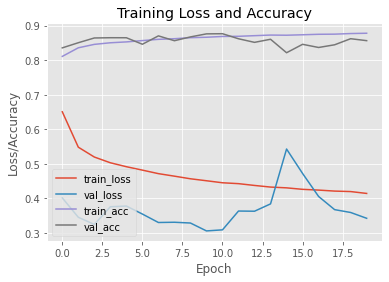

In [ ]:
# Plotting the graph
training_plot(MF, config.EPOCHS, config.PLOT_PATH)

In [ ]:
# Serialize/Writing the model to disk
print("Serializing network...")
fModel.save(config.MODEL_PATH, save_format="h5")

Serializing network...


In [ ]:
cp '/content/output/weights-010-0.3063.hdf5' 'gdrive/MyDrive/Colab Notebooks/Breast_Cancer_Classification/output'